# Investigate burst firing


## Imports

In [30]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats
#%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

import plotly.express as plx

In [2]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

## Load Original Data (Only Run Once)

In [ ]:
with open('data_bio482.pkl', 'rb') as file:
    data_df = pickle.load(file)

## Add AP Information (Only Run Once)

Using the Function_Detect_APs function, we can extract the details of the APs per sweep. For each entry in the original dataframe, we append the information about the APs in the Sweep_MembranePotential.

In [ ]:
def explain_ap(ap_params):
    return {
        'ap_thresh_vm': ap_params[1],
        'ap_peak_times': ap_params[2],
        'ap_peak_vm': ap_params[3],
        'ap_peak_amp': ap_params[4],
        'ap_duration': ap_params[5]
    }

In [ ]:
def process_sweep(row):
    """Process a single row to detect and explain action potentials."""
    sr_vm = row['Sweep_MembranePotential_SamplingRate']
    ap_vm_deriv_thresh = row['Cell_APThreshold_Slope']
    potential_across_time = row['Sweep_MembranePotential']

    # Detect action potentials
    ap_params = Function_Detect_APs(potential_across_time, sr_vm, ap_vm_deriv_thresh)

    # Return a dictionary of explained APs
    return {ap[0]: explain_ap(ap) for ap in ap_params}

In [ ]:
# #RUN TO REWITE
# # Apply the function to each row
# ap_info = data_df.apply(process_sweep, axis=1)
# data_df['ap_info'] = ap_info

In [ ]:
# #RUN TO REWRITE 
# file_to_save = "data_with_AP_info"
# #path = "/content/drive/MyDrive/NSCCM/" ## matthiew
# #data_df.to_pickle(f'{path}{file_to_save}.pkl')## matthiew
# data_df.to_pickle(f'{file_to_save}.pkl')   ## marine

## Import New Pickle

No need to run last 2 sections if you already have data_with_AP_info.pkl file in your directory. It is too large to push to github.

In [3]:
with open('data_with_AP_info.pkl', 'rb') as file:
    data_df = pickle.load(file)

## Visualise Data:

In [4]:
data_df.head()

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes,ap_info
0,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.044009375, -0.044028125, -0.0439875, -0.04...",20000.0,"[[4.567, 4.713], [7.327, 7.519], [14.481, 14.6...","[[0.002, 4.564], [4.606, 6.09], [14.634, 15.52...",2005.0,active touch,"[2.740000000000009, 2.740000000000009, 2.74000...",100.0,"[[6.118, 6.326], [7.942, 13.856]]","{1.3559: {'ap_thresh_vm': -0.033646875, 'ap_pe..."
1,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.046275, -0.04629375, -0.046259375, -0.0462...",20000.0,"[[15.274999999999999, 15.375], [16.247, 16.643...","[[0.002, 4.496], [5.558, 6.626], [13.406, 15.2...",2005.0,active touch,"[2.680000000000007, 2.680000000000007, 2.68000...",100.0,"[[4.7, 5.196], [6.696, 11.15], [12.032, 13.006...","{4.9021: {'ap_thresh_vm': -0.03423125, 'ap_pea..."
2,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.041896875, -0.0419125, -0.041909375, -0.04...",20000.0,"[[4.347000000000001, 7.0390000000000015], [8.2...","[[0.002, 2.128], [6.252, 7.01], [7.15, 20.0]]",2005.0,passive contact,"[1.4958937492820894, 1.5019819900587095, 1.509...",100.0,"[[2.15, 3.652], [4.362, 5.848]]","{2.13865: {'ap_thresh_vm': -0.03129375, 'ap_pe..."
3,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.04655625, -0.0465875, -0.046575, -0.046596...",20000.0,nan,"[[0.002, 2.764], [12.03, 14.464], [14.814, 15....",2005.0,active touch,"[2.467493802679826, 2.459711310964792, 2.46562...",100.0,"[[2.766, 12.026], [15.626, 18.406], [18.814, 1...","{0.91115: {'ap_thresh_vm': -0.033, 'ap_peak_ti..."
4,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.047296875, -0.047284375, -0.047265625, -0....",20000.0,"[[4.411000000000001, 4.4809999999999945], [5.2...","[[0.002, 3.36], [3.57, 4.424], [4.48, 5.224], ...",2005.0,active touch,"[2.4399999999999977, 2.4399999999999977, 2.440...",100.0,"[[5.228, 5.624], [7.462, 8.022], [11.002, 15.2...","{1.0954: {'ap_thresh_vm': -0.031940625, 'ap_pe..."


Each entry in the dataframe represents some sweep. There may be multiple sweeps per cell (as represented by Sweep_Counter) and so multiple entries with the same Cell_ID. Each entry has a Membrane Potential vs Time measure which can be visualised below:

In [133]:
def plot_aps(data_df, sweep_num, save_figure=False):

    sweep = data_df.iloc[sweep_num]

    sr_vm = sweep['Sweep_MembranePotential_SamplingRate']
    membrane_potential = sweep['Sweep_MembranePotential']
    
    time = [i/sr_vm for i in range(len(membrane_potential))]
    
    ap_peak_times = np.array([ap["ap_peak_times"] for ap in sweep["ap_info"].values()])
    ap_peak_vm = np.array([ap["ap_peak_vm"] for ap in sweep["ap_info"].values()])
    ap_thresh_vm = np.array([ap["ap_thresh_vm"] for ap in sweep["ap_info"].values()])
    ap_thresh_times = np.array([key for key in sweep["ap_info"].keys()])

    fig, ax = plt.subplots(1,1, figsize=(10,3), dpi=150)
    
    ax.set_title(f'APs for Sweep {sweep_num}')
    ax.plot(time, membrane_potential, lw=0.5,  zorder=0)
    ax.scatter(ap_peak_times, ap_peak_vm, lw=0.5, marker='+', color='r')
    ax.scatter(ap_thresh_times, ap_thresh_vm, lw=0.1, marker='o', color='b')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Vm (V)')
    plt.xlim(6,21)
    
    if save_figure:
        # Save figure
        fname = os.path.join('images', f'Example_Cell_{sweep_num}.png')
        plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')


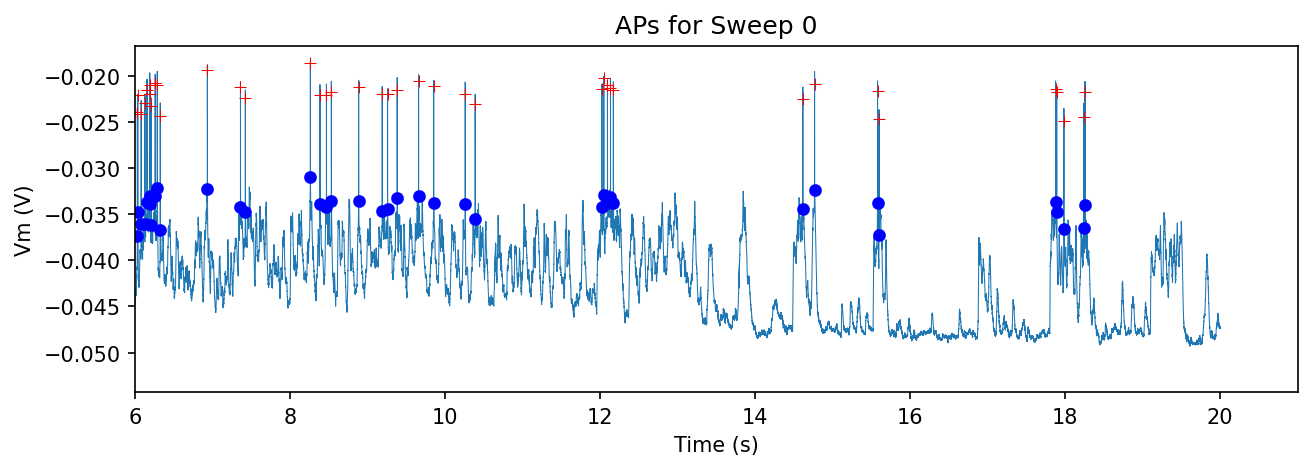

In [134]:
plot_aps(data_df, 0, save_figure = True)

## Define the average V_m thresholds AND average firing rate against cell types

In [140]:
data_df['length_of_sweep'] = data_df['Sweep_MembranePotential'].apply(len) / data_df['Sweep_MembranePotential_SamplingRate']
data_df['firing_rate'] = data_df['ap_info'].apply(len) / data_df['length_of_sweep']
mean_firing_rates = data_df.groupby(['Cell_Type', 'Sweep_Type'])['firing_rate'].mean()
mean_firing_rates

Cell_Type  Sweep_Type     
EXC        active touch        1.204910
           free whisking       1.611895
           passive contact     3.133333
PV         active touch       29.834527
           free whisking      33.164375
SST        active touch        7.084664
           free whisking       6.443781
VIP        active touch       19.533791
           free whisking       7.860121
Name: firing_rate, dtype: float64

In [144]:
mean_firing_rates = mean_firing_rates.drop('passive contact', level='Sweep_Type')
mean_firing_rates = mean_firing_rates.groupby('Cell_Type').mean()
mean_firing_rates

Cell_Type
EXC     1.408403
PV     31.499451
SST     6.764223
VIP    13.696956
Name: firing_rate, dtype: float64

In [156]:
# Custom aggregation function
def agg_function(values):
    result = []
    for value in values:
        if isinstance(value, dict):
            result.append(value)
        else:
            result.extend(value)
    return result

# Group and aggregate using the custom function
peak_per_type = data_df.groupby('Cell_Type')['ap_info'].agg(agg_function).reset_index()

In [157]:
def avg_vm_peak_thresh(dict_list):
    sum = 0
    count = 0
    for peak_dict in dict_list:
        if peak_dict.values():
            count += 1
            sum += list(peak_dict.values())[0]['ap_thresh_vm']
    return sum / len(dict_list)

peak_per_type['avg_vm_peak_thresh'] = peak_per_type['ap_info'].map(avg_vm_peak_thresh)

In [158]:
peak_per_type = peak_per_type.set_index('Cell_Type')['avg_vm_peak_thresh']

In [159]:
peak_per_type 

Cell_Type
EXC   -0.036862
PV    -0.041611
SST   -0.043215
VIP   -0.035094
Name: avg_vm_peak_thresh, dtype: float64

## Identify Bursts for one sweep 

In [222]:
SWEEP = 0

In [223]:
# define the sweep voltage transient, the mean sweep voltage threshold, and the time scale
type_vm_thresh = peak_per_type[data_df.iloc[SWEEP]['Cell_Type']]
type_fr = mean_firing_rates[data_df.iloc[SWEEP]['Cell_Type']]
sweep = data_df.iloc[SWEEP]
membrane_potential = sweep['Sweep_MembranePotential']

sr_vm = sweep['Sweep_MembranePotential_SamplingRate']
time = [i/sr_vm for i in range(len(membrane_potential))]

sweep_voltage = pd.Series(data=membrane_potential, index=time)
sweep_vm_thresh, 3 / (100 * type_fr)

(-0.03686245524549825, 0.02130072501823433)

In [224]:
ap_df = pd.DataFrame.from_dict(data_df.ap_info[SWEEP], orient='index') #The index (row labels) represents the timestamps of the AP peaks 

In [225]:
def find_min_vm_interval(sweep_voltage, start_time, end_time):
    return sweep_voltage.loc[start_time:end_time].min()

In [232]:
#APs occurring within 30 ms of each other are considered part of the same burst
ap_df['peak_end_time'] = ap_df.index + ap_df['ap_duration'] / 1000 #Calculate the time at which each action potential (AP) ends.
ap_df['time_since_last_AP'] = ap_df.index - ap_df['peak_end_time'].shift(1) #Compute the time elapsed since the end of the last AP
ap_df['time_since_last_AP_2x'] = ap_df.index - ap_df['peak_end_time'].shift(2) #Compute the time elapsed since the end of the AP two positions prior: ensures bursts are detected over multiple APs.

ap_df['min_vm_since_last_AP'] = 0
for i in range(len(ap_df)):
    ap_df['min_vm_since_last_AP'].iloc[i] = find_min_vm_interval(sweep_voltage, ap_df.index[i-1], ap_df.index[i])
ap_df['min_vm_since_last_AP'].iloc[0] = np.nan
ap_df['min_vm_since_last_AP_2x'] = np.minimum(ap_df['min_vm_since_last_AP'], ap_df['min_vm_since_last_AP'].shift(1))

ap_df['is_in_burst_defn1'] = ap_df['time_since_last_AP_2x'] < .03  #Identify if the AP is part of a burst based on timing.
ap_df['is_in_burst_defn1'] = ap_df['is_in_burst_defn1'] | ap_df['is_in_burst_defn1'].shift(-1) | ap_df['is_in_burst_defn1'].shift(-2)#Refine the identification of bursts by considering neighboring APs.

ap_df['is_in_burst_defn2'] = ap_df['time_since_last_AP_2x'] < 3 / (100 * type_fr)  #Identify if the AP is part of a burst based on timing AND Vm btw peaks
ap_df['is_in_burst_defn2'] = ap_df['is_in_burst_defn2'] | ap_df['is_in_burst_defn2'].shift(-1) | ap_df['is_in_burst_defn2'].shift(-2)#Refine the identification of bursts by considering neighboring APs.

ap_df['is_in_burst_defn3'] = (ap_df['time_since_last_AP_2x'] < 3 / (100 * type_fr)) & (ap_df['min_vm_since_last_AP_2x'] > type_vm_thresh) #Identify if the AP is part of a burst based on timing AND Vm btw peaks
ap_df['is_in_burst_defn3'] = ap_df['is_in_burst_defn3'] | ap_df['is_in_burst_defn3'].shift(-1) | ap_df['is_in_burst_defn3'].shift(-2)#Refine the identification of bursts by considering neighboring APs.


ap_df

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/3649259209.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ap_thresh_vm,ap_peak_times,ap_peak_vm,ap_peak_amp,ap_duration,peak_end_time,time_since_last_AP,time_since_last_AP_2x,min_vm_since_last_AP,min_vm_since_last_AP_2x,is_in_burst_defn1,is_in_burst_defn2,is_in_burst_defn3
0.10770,-0.049272,0.10810,-0.007141,0.042131,0.60,0.10830,NaN,NaN,NaN,NaN,False,False,False
0.14205,-0.047831,0.14255,-0.005894,0.041937,0.60,0.14265,0.03375,NaN,-0.054300,NaN,False,False,False
1.10000,-0.049078,1.10040,-0.006591,0.042488,0.60,1.10060,0.95735,0.99170,-0.064109,-0.064109,False,False,False
1.96965,-0.049688,1.97010,-0.005888,0.043800,0.55,1.97020,0.86905,1.82700,-0.065244,-0.065244,False,False,False
2.35705,-0.049950,2.35750,-0.005400,0.044550,0.55,2.35760,0.38685,1.25645,-0.064850,-0.065244,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19.67145,-0.047659,19.67190,-0.004409,0.043250,0.55,19.67200,0.03035,0.07810,-0.056419,-0.059987,False,False,False
19.82340,-0.048687,19.82385,-0.005525,0.043162,0.60,19.82400,0.15140,0.18230,-0.063356,-0.063356,False,False,False
19.86555,-0.047741,19.86605,-0.004078,0.043662,0.60,19.86615,0.04155,0.19355,-0.061613,-0.063356,False,False,False
19.88695,-0.048000,19.88745,-0.004362,0.043638,0.60,19.88755,0.02080,0.06295,-0.057447,-0.061613,False,False,False


In [227]:
def burst_times(ap_df):
    '''identify and extract bursts of activity from the action potential (AP) data in ap_df.
    A burst is defined based on the criteria already encoded in the is_in_burst column of ap_df
    
    - ap_df (DataFrame) containing 'is_in_burst' column indicating whether each AP is part of a burs,
            and a 'peak_end_time' column for the end time of each AP.
            
    Returns :
    bursts: A list of tuples representing bursts. Each tuple contains:
        Burst start time (burst_start).
        Burst end time (burst_end).
        Number of APs in the burst (j - i + 1).
    '''
    bursts = []
    for defn in (1,2,3):
        i = 0
        this_sweep_bursts = []
        while i < len(ap_df):
        
            row = ap_df.iloc[i]
            is_in_burst = row[f'is_in_burst_defn{defn}']
            if is_in_burst:
                burst_start = row.name
                for j in range(i, len(ap_df)):
                    row_1 = ap_df.iloc[j]
                    if j == len(ap_df)-1:
                        # we have reached last peak in sweep
                        burst_end = row_1['peak_end_time']
                        this_sweep_bursts.append((burst_start, burst_end, j-i+1))
                        break
                    row_2 = ap_df.iloc[j+1]
                    if not row_2[f'is_in_burst_defn{defn}']:
                        # we have reached peak which is not in this burst
                        burst_end = row_1['peak_end_time']
                        this_sweep_bursts.append((burst_start, burst_end, j-i+1))
                        break
                    else:
                        continue
                i = j
            i += 1
        bursts.append(this_sweep_bursts)
    return bursts

In [228]:
bursts = burst_times(ap_df)

In [229]:
bursts

[[(6.18955, 6.209849999999999, 3)], [(6.18955, 6.209849999999999, 3)], []]

## FILTER 1: V_threshold for Peaks for Singular Sweeps

Filter the bursts such that we remove bursts whose membrane potential falls below the cell type's average V_m threshold

### With this threshold, filter out bursts

## Bursts for all sweeps

In [235]:
#RUN TO REWRITE 
burst_times_per_sweep = []

for i in range(len(data_df)):
    if i % 10 == 0:
        print(f"completing sweep {i+1}")
    ap_df = pd.DataFrame.from_dict(data_df.ap_info[i], orient='index')
    if len(ap_df):
        type_vm_thresh = peak_per_type[data_df.iloc[i]['Cell_Type']]
        type_fr = mean_firing_rates[data_df.iloc[i]['Cell_Type']]
        sweep = data_df.iloc[i]
        membrane_potential = sweep['Sweep_MembranePotential']
        
        sr_vm = sweep['Sweep_MembranePotential_SamplingRate']
        time = [i/sr_vm for i in range(len(membrane_potential))]
        
        sweep_voltage = pd.Series(data=membrane_potential, index=time)
        
        ap_df['peak_end_time'] = ap_df.index + ap_df['ap_duration'] / 1000 #Calculate the time at which each action potential (AP) ends.
        ap_df['time_since_last_AP'] = ap_df.index - ap_df['peak_end_time'].shift(1) #Compute the time elapsed since the end of the last AP
        ap_df['time_since_last_AP_2x'] = ap_df.index - ap_df['peak_end_time'].shift(2) #Compute the time elapsed since the end of the AP two positions prior: ensures bursts are detected over multiple APs.
        
        ap_df['min_vm_since_last_AP'] = 0
        for i in range(len(ap_df)):
            ap_df['min_vm_since_last_AP'].iloc[i] = find_min_vm_interval(sweep_voltage, ap_df.index[i-1], ap_df.index[i])
        ap_df['min_vm_since_last_AP'].iloc[0] = np.nan
        ap_df['min_vm_since_last_AP_2x'] = np.minimum(ap_df['min_vm_since_last_AP'], ap_df['min_vm_since_last_AP'].shift(1))
        
        ap_df['is_in_burst_defn1'] = ap_df['time_since_last_AP_2x'] < .03  #Identify if the AP is part of a burst based on timing.
        ap_df['is_in_burst_defn1'] = ap_df['is_in_burst_defn1'] | ap_df['is_in_burst_defn1'].shift(-1) | ap_df['is_in_burst_defn1'].shift(-2)#Refine the identification of bursts by considering neighboring APs.
        
        ap_df['is_in_burst_defn2'] = ap_df['time_since_last_AP_2x'] < 3 / (100 * type_fr)  #Identify if the AP is part of a burst based on timing AND Vm btw peaks
        ap_df['is_in_burst_defn2'] = ap_df['is_in_burst_defn2'] | ap_df['is_in_burst_defn2'].shift(-1) | ap_df['is_in_burst_defn2'].shift(-2)#Refine the identification of bursts by considering neighboring APs.
        
        ap_df['is_in_burst_defn3'] = (ap_df['time_since_last_AP_2x'] < 3 / (100 * type_fr)) & (ap_df['min_vm_since_last_AP_2x'] > type_vm_thresh) #Identify if the AP is part of a burst based on timing AND Vm btw peaks
        ap_df['is_in_burst_defn3'] = ap_df['is_in_burst_defn3'] | ap_df['is_in_burst_defn3'].shift(-1) | ap_df['is_in_burst_defn3'].shift(-2)#Refine the identification of bursts by considering neighboring APs.

        burst_info = burst_times(ap_df)
        burst_times_per_sweep.append(burst_info)
    else:
        print(f"found no peaks")
        burst_times_per_sweep.append([]) 
    

completing sweep 1


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

found no peaks
completing sweep 11


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 21


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 31
found no peaks
found no peaks


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 41


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

found no peaks
found no peaks
found no peaks


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



completing sweep 51


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



found no peaks
found no peaks


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



completing sweep 61
found no peaks


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



found no peaks


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 71


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

found no peaks
found no peaks
found no peaks
completing sweep 81
found no peaks


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 91
found no peaks
found no peaks
found no peaks
found no peaks


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



found no peaks
completing sweep 101


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

found no peaks
found no peaks
completing sweep 111


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 121


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 131
found no peaks
found no peaks
found no peaks


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 141


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 151


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 161
found no peaks


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 171


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

found no peaks
found no peaks
found no peaks
completing sweep 181
found no peaks
found no peaks


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 191
found no peaks
found no peaks
found no peaks
found no peaks
found no peaks
found no peaks
found no peaks


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



completing sweep 201


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 211


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 221


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 231


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 241


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 251


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 261


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 271


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 281


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 291


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 301


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 311


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 321


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 331


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 341


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 351


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 361


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 371


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 381


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 391


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 401


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 411


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 421


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 431


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 441


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 451


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 461


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 471


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 481


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 491


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 501


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 511


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 521


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 531


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 541


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 551


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 561


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 571


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 581


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 591


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 601


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 611


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 621


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 631


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

found no peaks


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



completing sweep 641


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



found no peaks
found no peaks
found no peaks
found no peaks
found no peaks
found no peaks
found no peaks
found no peaks
completing sweep 651
found no peaks
found no peaks
found no peaks
found no peaks
found no peaks


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



found no peaks


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



completing sweep 661


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 671


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 681


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

found no peaks
completing sweep 691


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 701


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 711


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 721


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 731


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 741


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 751


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

found no peaks


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



completing sweep 761


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

found no peaks


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 771


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 781


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 791


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 801


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 811


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 821


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipyker

completing sweep 831


/var/folders/l9/4_w6ngzx01q69sxyzp_vrs6r0000gn/T/ipykernel_18322/237334083.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [236]:
len(burst_times_per_sweep)

831

In [237]:
burst_times_per_sweep

[[[(6.18955, 6.209849999999999, 3)], [(6.18955, 6.209849999999999, 3)], []],
 [[(6.9207, 7.02135, 7),
   (7.11825, 7.148499999999999, 3),
   (9.7317, 9.761800000000001, 4),
   (10.6295, 10.6485, 3)],
  [(9.7317, 9.761800000000001, 4), (10.6295, 10.6485, 3)],
  [(9.7317, 9.761800000000001, 4), (10.6295, 10.6485, 3)]],
 [[(2.2695, 2.28755, 3),
   (4.4129, 4.43405, 3),
   (4.69525, 4.719049999999999, 3),
   (4.82825, 4.88225, 6),
   (5.52505, 5.637549999999999, 9)],
  [(2.2695, 2.28755, 3),
   (4.4129, 4.43405, 3),
   (4.85645, 4.88225, 4),
   (5.52505, 5.5503, 4)],
  [(2.2695, 2.28755, 3),
   (4.4129, 4.43405, 3),
   (4.85645, 4.88225, 4),
   (5.52505, 5.5503, 4)]],
 [[(0.91115, 0.94065, 3),
   (2.74875, 2.78715, 4),
   (2.89315, 2.9213, 3),
   (3.8196, 3.90045, 8),
   (3.97045, 3.98815, 3),
   (4.06895, 4.098199999999999, 4),
   (4.1552, 4.18565, 4),
   (4.3851, 4.5423, 10),
   (4.7874, 4.84125, 5),
   (4.9521, 5.178249999999999, 13),
   (5.2932, 5.317399999999999, 3),
   (5.38785, 5.54

In [238]:
#RUN TO REWRITE 

file_path = "data_with_burst_info_3defns.txt"

# Write the list to a text file
with open(file_path, "w") as file:
   for item in burst_times_per_sweep:
       file.write(f"{item}\n")

#### Add burst info for each sweep to the data_df dataftame   

In [ ]:
#load burst_times_per_sweep
import ast

file_path = "data_with_burst_info.txt"
burst_times_per_sweep = []
# Open and read the text file
with open(file_path, "r") as file:
    for line in file:
        burst_times_per_sweep.append(ast.literal_eval(line.strip()))

In [ ]:
# add a column to data_df containing burst_times_per_sweep
# each sweep has format [(start, stop, nb_of_ap), (start, stop, nb_of_ap), ...]
data_df['burst_info'] = burst_times_per_sweep

# add col for nb of burts 
data_df['nb_of_bursts'] = data_df['burst_info'].apply(len)

#add col for mean burst duration ->TODO check is there is a lot of diversity in the duration : pertinent to do mean ?
def mean_burst_duration(burst_inf):
    if not burst_inf:
        return 0
    durations = [stop-start for start, stop, _ in burst_inf]
    return sum(durations)/len(durations)

data_df['mean_burst_duration_sweep'] = data_df['burst_info'].apply(lambda x: mean_burst_duration(x) )

In [ ]:
data_df

## Analyse bursting behavior of neurons 

### Define metrics to categorise neurons according to their bursting behavior:
- mean number of burst 
- mean burst duration

In [ ]:
def plot_metrics(df_metric, x):
    '''
    plots subplots of all metrics for x
    
    - df_metric (DataFrame): dataframe with 1 column x and multiple colums for metrics (but no other kind of columns)
    - x (str): the x axis (ex 'Cell_Type' or 'Cell_layer') 
    '''
    # create list of metrics : columns except x
    metrics = df_metric.columns.difference([x])

    # Create subplots dynamically
    fig, axes = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), 6), sharey=False)

    # color palette based on the unique x values
    palette_x = sns.color_palette("Set2", n_colors=len(df_metric[x].unique()))

    # Iterate through metrics and plot each one
    for ax, metric in zip(axes, metrics):
        ax.bar(df_metric[x], df_metric[metric], color=palette_x)
        ax.set_xlabel(x)
        ax.set_ylabel(metric.replace('_', ' ').capitalize())
        ax.set_title(f'{metric.replace("_", " ").capitalize()} by {x}')

    plt.tight_layout()
    plt.show()

#### Per cell type

In [ ]:
# Calculate metrics
mean_nb_burst_cell_type = data_df.groupby('Cell_Type')['nb_of_bursts'].mean()
mean_burst_duration_cell_type = data_df.groupby('Cell_Type')['mean_burst_duration_sweep'].mean()

# Create DataFrame and combine metrics
cell_type_metrics = pd.DataFrame({
    'Cell_Type': mean_nb_burst_cell_type.index,
    'mean_nb_bursts': mean_nb_burst_cell_type.values,
    'mean_burst_duration': mean_burst_duration_cell_type.values
})
cell_type_metrics

In [ ]:
plot_metrics(cell_type_metrics, 'Cell_Type')

#### Per cell layer

In [ ]:
# Calculate metrics
mean_nb_burst_layer = data_df.groupby('Cell_Layer')['nb_of_bursts'].mean()
mean_burst_duration_layer = data_df.groupby('Cell_Layer')['mean_burst_duration_sweep'].mean()

# Create DataFrame and combine metrics
layer_metrics = pd.DataFrame({
    'Cell_Layer': mean_nb_burst_layer.index,
    'mean_nb_bursts': mean_nb_burst_layer.values,
    'mean_burst_duration': mean_burst_duration_layer.values
})

In [ ]:
plot_metrics(layer_metrics,'Cell_Layer')

### Cell depth 

In [ ]:
# Calculate metrics
mean_nb_burst_depth = data_df.groupby('Cell_Depth')['nb_of_bursts'].mean()
mean_burst_duration_depth = data_df.groupby('Cell_Depth')['mean_burst_duration_sweep'].mean()

# Create DataFrame and combine metrics
depth_metrics = pd.DataFrame({
    'Cell_Depth': mean_nb_burst_depth.index,
    'mean_nb_bursts': mean_nb_burst_depth.values,
    'mean_burst_duration': mean_burst_duration_depth.values
})

In [ ]:
plot_metrics(depth_metrics, 'Cell_Depth')

### Targeted brain area

In [ ]:
# Calculate metrics
mean_nb_burst_area = data_df.groupby('Cell_TargetedBrainArea')['nb_of_bursts'].mean()
mean_burst_duration_area = data_df.groupby('Cell_TargetedBrainArea')['mean_burst_duration_sweep'].mean()

# Create DataFrame and combine metrics
area_metrics = pd.DataFrame({
    'Cell_TargetedBrainArea': mean_nb_burst_area.index,
    'mean_nb_bursts': mean_nb_burst_area.values,
    'mean_burst_duration': mean_burst_duration_area.values
})

In [ ]:
plot_metrics(area_metrics,'Cell_TargetedBrainArea')

## activities maping

In [ ]:
data_df.columns

In [ ]:
#adding a column for timepoints: array of all timepoints where measures were made
sampling_rate = data_df['Sweep_MembranePotential_SamplingRate'].iloc[0] #always the same 20000.
data_df['time_points'] = data_df['Sweep_MembranePotential'].apply(lambda x: np.linspace(0, len(x)/sampling_rate, num=len(x)))


In [ ]:
#adding a column to data_df corresonding to a burst boolean of each timepoint 
def compute_burst_filter(time_points, burst_info):
    # Create a zero array of the same length as time_points
    burst_filter = np.zeros(len(time_points), dtype=int)
    
    # Iterate through each (start, end, n) tuple in burst_info
    for start, end, _ in burst_info:
        # Mark indices where time_points are within the burst interval
        burst_filter[(time_points >= start) & (time_points <= end)] = 1
    
    return burst_filter

data_df['burst_filter'] = data_df.apply(lambda row: compute_burst_filter(np.array(row['time_points']), row['burst_info']), axis=1)

In [ ]:
#adding columns to data_df corresonding to actions(wisking, rest...) boolean of each timepoint 
def compute_action_filter(time_points, action_times):
    ''' 
    computes the filter for a single row of data_df
    returns the filter : list of o and 1 indicating if the timpoint corresponds to the action
    '''
    # Check for NaN or invalid cases : if no action, retun list of false
    if action_times is None or len(action_times) == 0 or not isinstance(action_times, list):
        return np.zeros(len(time_points), dtype=int)
    if time_points is None or len(time_points) == 0 or not isinstance(time_points, (list, np.ndarray)):
        return np.zeros(len(time_points), dtype=int)
    
    # Create a zero array of the same length as time_points
    burst_filter = np.zeros(len(time_points), dtype=int)
    # Iterate through each (start, end) tuple in action_times
    for start, end in action_times:
        # Mark indices where time_points are within the burst interval
        burst_filter[(time_points >= start) & (time_points <= end)] = 1
    
    return burst_filter


In [ ]:
data_df['quiet_filter'] = data_df.apply(lambda row: compute_action_filter(np.array(row['time_points']),row['Sweep_QuietTimes']), axis=1)
data_df['wisking_filter'] = data_df.apply(lambda row: compute_action_filter(np.array(row['time_points']),row['Sweep_WhiskingTimes']), axis=1)

In [ ]:

data_df['a_contact_filter'] = data_df.apply(lambda row: compute_action_filter(np.array(row['time_points']),row['Sweep_ActiveContactTimes']), axis=1)
data_df['p_contact_filter'] = data_df.apply(lambda row: compute_action_filter(np.array(row['time_points']),row['Sweep_PassiveContactTimes']), axis=1)

In [ ]:
data_df['burst_filter'].isnull().unique()

In [ ]:
# adding filters for action and bursting 
data_df['burst_filter'] = 

In [ ]:
data_df['Sweep_ActiveContactTimes']


In [ ]:
data_df['Sweep_PassiveContactTimes']
